In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_stock_money_data

In [2]:
#获取行业分类
industrys = DP.get_industrys('L2')

In [3]:
#industrys

In [82]:
industry=['801080.SI',
          '801760.SI',
          '801740.SI',
          '801750.SI',
          '801010.SI',
          '801770.SI',
         ]
industry = ['801178.SI']
#industry='all'
#取行业内股票数据
data = DP.get_daily_data(industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])

#money_dic = get_stock_money_data(industry)

In [83]:
#rzrqye = DataFrame(np.log((money_dic['rzye'] - money_dic['rqye']).fillna(method='bfill')), index=OPEN.index).fillna(method='bfill')
#gt_vol = DataFrame(np.log(money_dic['gt_vol'].fillna(method='bfill')), index=OPEN.index).fillna(method='bfill')

#d_rzrqye = (rzrqye - rzrqye.shift()).fillna(0)
#d_gt_vol = (gt_vol - gt_vol.shift()).fillna(0)

In [84]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)
tmv = mv ** 3

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

In [85]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [86]:
n = 2
y = standardize_industry(ror.rolling(n).sum().shift(-n+1) - r_geye, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [87]:
x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei, industrys, industry).rolling(1).mean().shift(1)
x3 = standardize_industry(r_rinei, industrys, industry).rolling(1).mean().shift(2)
x4 = standardize_industry(r_rinei, industrys, industry).rolling(2).mean().shift(3)
x5 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(5)
x6 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(10)
x7 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(15)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye, industrys, industry).rolling(1).mean().shift(1)
z3 = standardize_industry(r_geye, industrys, industry).rolling(1).mean().shift(2)
z4 = standardize_industry(r_geye, industrys, industry).rolling(2).mean().shift(3)
z5 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(5)
z6 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(10)
z7 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(15)

u1 = standardize_industry(ror, industrys, industry)
u2 = standardize_industry(ror, industrys, industry).rolling(1).mean().shift(1)
u3 = standardize_industry(ror, industrys, industry).rolling(1).mean().shift(2)
u4 = standardize_industry(ror, industrys, industry).rolling(2).mean().shift(3)
u5 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(5)
u6 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(10)
u7 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(15)

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh, industrys, industry).rolling(1).mean().shift(1)
h3 = standardize_industry(rh, industrys, industry).rolling(1).mean().shift(2)
h4 = standardize_industry(rh, industrys, industry).rolling(2).mean().shift(3)
h5 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(5)
h6 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(10)
h7 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(15)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl, industrys, industry).rolling(1).mean().shift(1)
l3 = standardize_industry(rl, industrys, industry).rolling(1).mean().shift(2)
l4 = standardize_industry(rl, industrys, industry).rolling(2).mean().shift(3)
l5 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(5)
l6 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(10)
l7 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(15)

hl1 = standardize_industry(hl, industrys, industry)
hl2 = standardize_industry(hl, industrys, industry).rolling(1).mean().shift(1)
hl3 = standardize_industry(hl, industrys, industry).rolling(1).mean().shift(2)
hl4 = standardize_industry(hl, industrys, industry).rolling(2).mean().shift(3)
hl5 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(5)
hl6 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(10)
hl7 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(15)

vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr, industrys, industry).rolling(1).mean().shift(1)
vr3 = standardize_industry(vr, industrys, industry).rolling(1).mean().shift(2)
vr4 = standardize_industry(vr, industrys, industry).rolling(2).mean().shift(3)
vr5 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(5)
vr6 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(10)
vr7 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(15)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)

mv = standardize_industry(mv, industrys, industry)
lmv = standardize_industry(lmv, industrys, industry)
tmv = standardize_industry(tmv, industrys, industry)

#rzrq = standardize_industry(d_rzrqye, industrys, industry).rolling(5).mean()
#gt = centralize(d_gt_vol).rolling(5).mean()

In [88]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5, 'x6':x6, 'x7':x7,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5, 'z6':z6, 'z7':z7,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5, 'u6':u6, 'u7':u7,
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5, 'h6':h6, 'h7':h7,
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5, 'l6':l6, 'l7':l7,
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5, 'hl6':hl6, 'hl7':hl7,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5, 'vr6':vr6, 'vr7':vr7,
    'pe':pe, 'pb':pb, 'ps':ps,
    'mv':mv, 'lmv':lmv, 'tmv':tmv,
    #'rzrq':rzrq, 'gt':gt,
}

In [89]:
begin_date = '2010-01-01'
split_date = '2012-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [90]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [91]:
#df_train.corr().iloc[0,:].sort_values()

In [92]:
model = smf.ols('y~x1+x2+x4\
                  +z4\
                  \
                  +h1+h2\
                  \
                  \
                  +vr1\
                  \
                  +pe+pb+ps\
                  +lmv', data=df_train).fit()
model.tvalues

Intercept   -0.212396
x1          -0.355280
x2          -2.547200
x4          -3.449340
z4          -2.356139
h1          -0.087420
h2           0.903134
vr1         -1.451882
pe           1.969206
pb           1.975293
ps           0.496615
lmv         -2.443691
dtype: float64

002682.SZ    0.105054
603813.SH    0.099000
600153.SH    0.093642
603128.SH    0.091195
600575.SH    0.089351
600057.SH    0.082377
601598.SH    0.071951
002800.SZ    0.070510
600787.SH    0.068966
603066.SH    0.066081
Name: 2020-07-17 00:00:00, dtype: float64


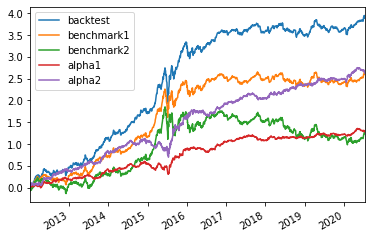

In [96]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q = 1 - 5 / len(y_hat.columns)
position = (y_hat.gt(y_hat.quantile(q, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [70]:
ror_huice.mean(1).iloc[-20:]

2020-06-18   -0.006534
2020-06-19   -0.002919
2020-06-22    0.019538
2020-06-23    0.026032
2020-06-24   -0.012066
2020-06-29   -0.000093
2020-06-30    0.003411
2020-07-01    0.004603
2020-07-02    0.010302
2020-07-03    0.018517
2020-07-06    0.026827
2020-07-07    0.019134
2020-07-08    0.033405
2020-07-09    0.008284
2020-07-10    0.008123
2020-07-13    0.025222
2020-07-14   -0.033527
2020-07-15   -0.057642
2020-07-16   -0.027970
2020-07-17         NaN
dtype: float64

In [29]:
position.sum(1)

2012-01-04    0
2012-01-05    5
2012-01-06    5
2012-01-09    5
2012-01-10    5
             ..
2020-07-13    9
2020-07-14    9
2020-07-15    9
2020-07-16    9
2020-07-17    9
Length: 2075, dtype: int64

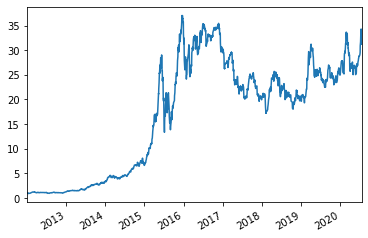

In [30]:
(ror_huice.mean(1)-0.0008+1).cumprod().plot()

In [1382]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300209.SZ    0.192616
300803.SZ    0.154640
600855.SH    0.145568
300687.SZ    0.141097
300368.SZ    0.139459
300465.SZ    0.131158
300448.SZ    0.117734
300541.SZ    0.115167
300277.SZ    0.107636
300248.SZ    0.106496
Name: 2020-07-16 00:00:00, dtype: float64


In [465]:
df_train = df_train.dropna()
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

array([0.05159753, 0.05007378, 0.04443164, 0.04619165, 0.04480049,
       0.04128151, 0.04127881, 0.05454827, 0.05270984, 0.05264996,
       0.04963717, 0.05406033, 0.04655707, 0.04854932, 0.0502602 ,
       0.0494474 , 0.04531465, 0.04479211, 0.04590302, 0.0421521 ,
       0.04376315])

In [11]:
d = {1:1}

In [13]:
d.update({2:2})

In [14]:
d

{1: 1, 2: 2}